# DATA CLEANING
*This dataset consists of used cars from eBay Kleinanzeigen, a classifieds section of the German eBay website. This project aims to clean the data and analyze the included used car listings.*

### TABLE OF CONTENTS:

* [Basic data exploration](#EDA)
* [Observation summary](#obs_sum)
* [Data cleaning](#data_cleaning)
    * [Edit column names](#edit_col_names)
    * [Date formatting](#handle_dates)
    * [Convert numeric columns numeric dtype](#text_num)
    * [Regex to replace characters](#replace_non_num)
    * [Aggregate numeric column](#num_col_analysis)
    * [Check labelling of categorical column](#cat_label)
* [Outliers](#detect_outliers)
    * [Outlier visualisation using boxplot](#boxplot)
    * [Remove outliers](#remove_outliers)
        * [Handle outliers using IQR method](#IQR)
        * [Handle outliers using z-score method](#z-score)
* [Missing values](#missing_values)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# To print in a better format
def print_data_info(header_add, header, func):
    print('\n', '=+'*50,'\n', header_add, header, ':\n','=+'*50, '\n', func)

# DATA CLEANING<a class="anchor" id="data_cleaning"></a>

# Basic data exploration<a class="anchor" id="EDA"></a>

In [ ]:
# Load data, default encoding is UTF-8, try Latin-1 and Windows-1252 for encoding erors
autos = pd.read_csv('autos.csv', encoding = 'Windows-1252')

print_data_info( '-','The shape of the dataset is : ', autos.shape)

In [ ]:
# Load data, default encoding is UTF-8, try Latin-1 and Windows-1252 for encoding erors
autos = pd.read_csv('autos.csv', encoding = 'Windows-1252')

print_data_info( '-','The shape of the dataset is : ', autos.shape)

print('=====================================================')
print('NAs/Missing values in the data')
print('=====================================================')
# check NAs in the data. .isnull() gives boolean values, the sum gives total number of nas. I divided it further by total number of rows to get the percentage of data in null.
print(autos.isnull().sum()/autos.shape[0]*100)

print('=====================================================')
print('Top 5 rows in the data')
print('=====================================================')
print(autos.head())

print('=====================================================')
print('Describe function to check abnormalities, outliers')
print('=====================================================')
# .describe only includes numeric columns, adding include='all' will include all the columns with different dtypes is included.
autos.describe(include='all')
# yearOfRegistration,  monthOfRegistration, postalCode are stored as numeric dtypes. Where as price and odometer columns are saved as strings. 

# Observations summary<a class="anchor" id="obs_sum"></a>
Based on the observations made from the above exploration following data cleaning is needed.

* The column names use camelcase instead of Python's preferred snakecase, which means we can't just replace spaces with underscores therefore convert the column names from camelcase to snakecase and reword some of the column names based on the data dictionary to be more descriptive.

* Convert columns like dateCrawled, dateCreated and lastSeen to timestamps to be able to extract dates, year, month, time etc. 

* Some of the columns like vehicle_type, gear_box, model, fuel_type, notRepairedDamage have missing values. This values can be imputed or removed from the data.

* The column'yearOfRegistration'has min value of 1000 (before cars were invented) and max of 9999 (many years into the future). these datapoints do not make sense. We might need to remove such data.

* Price and odometer column are numeric columns. Remove any non-numeric characters and convert the column to numeric dtype. Add 'dollar' and 'km' to the column name to be descriptive. Once the column is converted to numeric dtype, check for outlier and anomalies in the data and remove them.

* Some columns have null values. The column 'notRepairedDamage' has highest null values but none have more than ~20% null values. We might want to drop these values or replace them. Lets decide post further exploration.



# Data Cleaning<a class="anchor" id="data_cleaning"></a>

## Edit column names<a class="anchor" id="edit_col_names"></a>
Let's convert the column names from camelcase to snakecase and reword some of the column names based on the data dictionary to be more descriptive.

In [4]:
print('=====================================================')
print('Before changing column names')
print('=====================================================')
print(list(autos.columns))

# Copy the array of column names to convert the names to snake case and reword some column names
autos.rename({'dateCrawled': 'date_crawled',
 'offerType':'offer_type',
 'vehicleType': 'vehicle_type',
 'yearOfRegistration': 'registration_year',
 'monthOfRegistration':'registration_month',
 'fuelType':'fuel_type',
 'price' : 'price_dollar',
 'odometer' : 'odometer_km',
 'notRepairedDamage':'unrepaired_damage',
 'dateCreated':'ad_created',
 'nrOfPictures':'number_pictures_ad',
 'postalCode': 'postal_code',
 'lastSeen':'last_seen'}, axis='columns', inplace =True)

# To ensure all the cases are lower for consistency
autos.columns = autos.columns.str.lower() 

print('=====================================================')
print('After changing column names')
print('=====================================================')
print(list(autos.columns))

Before changing column names
['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'odometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']
After changing column names
['date_crawled', 'name', 'seller', 'offer_type', 'price_dollar', 'abtest', 'vehicle_type', 'registration_year', 'gearbox', 'powerps', 'model', 'odometer_km', 'registration_month', 'fuel_type', 'brand', 'unrepaired_damage', 'ad_created', 'number_pictures_ad', 'postal_code', 'last_seen']


## Date column formatting<a class="anchor" id="handle_dates"></a>


In [5]:
# Datetime columns can be converted to DateTime formatting using pd.to_datetime function where you can specify the format you are looking for e.g. :  format='%Y-%m-%d %H:%M:%S.%f'
dates_cols = ['date_crawled','ad_created','last_seen', 'registration_year', 'registration_month']

# Since only first three columns require date formatting, lets slice dates_cols in the below code.
autos[dates_cols[:3]] = autos[dates_cols[:3]].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
autos[['date_crawled','ad_created','last_seen']].head()

# you can use .dt.date or .dt.year or .dt.month function to extract date, year, month respectively form the above columns.
autos['date_crawled'].dt.date[:5]

0    2016-03-26
1    2016-04-04
2    2016-03-26
3    2016-03-12
4    2016-04-01
Name: date_crawled, dtype: object

In [6]:
autos[dates_cols].describe()
# As per the observation made in the preliminary data analysis, the column'yearOfRegistration'has min value of 1000 (before cars were invented) and max of 9999 (many years into the future). These datapoints do not make sense. Let's count the number of listings with cars that fall outside the 1904 - 2016 interval (Since the first car was registered in 1904) and see if it's safe to remove those rows entirely, or if we need more custom logic.

,registration_year,registration_month
count,50000.000000,50000.000000
mean,2005.073280,5.723360
std,105.712813,3.711984
min,1000.000000,0.000000
25%,1999.000000,3.000000
50%,2003.000000,6.000000
75%,2008.000000,9.000000
max,9999.000000,12.000000


In [7]:
((50000 - autos['registration_year'].between(1904, 2016).sum())/50000)*100
# 4% of the data has incorrect information. for now lets delete this data. Based on the study goals, this data can be imputed by replacing it with mode, median or by predicting the values using a model.

3.9440000000000004

In [8]:
autos = autos[autos['registration_year'].between(1904, 2016)]
# review frequency percentage after removing incorrect entries. I have sliced it for first 10 observations.
print('First 10 entries sorted by values')
print('=======================================================')
print((pd.value_counts(autos['registration_year'].values, sort=True, normalize=True)*100)[:10])

# To rank by date in ascending order (earliest to latest), we can chain the Series.sort_index() method.  I have sliced it for first 10 observations.
print('First 10 entries sorted by index(date)')
print('=======================================================')
pd.value_counts(autos['registration_year'].values, sort=True, normalize=True).sort_index()[:10]

First 10 entries sorted by values
2000    6.983426
2005    6.277588
1999    6.246356
2004    5.698759
2003    5.677938
2006    5.638378
2001    5.627967
2002    5.274007
1998    5.107437
2007    4.797202
dtype: float64
First 10 entries sorted by index(date)


1910    0.000187
1927    0.000021
1929    0.000021
1931    0.000021
1934    0.000042
1937    0.000083
1938    0.000021
1939    0.000021
1941    0.000042
1943    0.000021
dtype: float64

## Regex to replace characters<a class="anchor" id="replace_non_num"></a>
#### A brief explanation on REGEX usage
* Step 1 -- Specify class, its specified within square brackets []. To find ABC you can specify [ABCD] or [A-D], for 1,2,3,4,5 [1-5].

* Step 2 -- You can match the characters not listed within the class by complementing the set. This is indicated by including a '^' as the first character of the class; '^'. for example if you want to find digits you can specify [^A-Z]
You can match the characters not listed within the class by complementing the set.



In [9]:
# we can use .replace to remove the characters we want to remove. The only drawback in this method is must know all the characters that needs to be removed in any given column.
autos['price_dollar'] = autos['price_dollar'].str.replace('$', '').str.replace(',', '').astype('float')

# lets use regex within replace to remove all non numeric characters. Double bracket represents a class you want to find, carrot sign before class represents complementing set. 0 and 9 seperated by hyphen represents a range. Therefore [^0-9] represents non-numeric characters. 
autos['odometer_km'] = autos['odometer_km'].str.replace('[^0-9]', '').astype('float')
# Now that we have converted two variables price and odometer to numeric, we can rerun describe function to analyze minimum and maximum values and look for any values that look unrealistically high or low (outliers) that we might want to remove.

In [10]:
autos.describe()
#This time we won't add include = 'all'

,price_dollar,registration_year,powerps,odometer_km,registration_month,number_pictures_ad,postal_code
count,4.802800e+04,48028.00000,48028.000000,48028.000000,48028.000000,48028.0,48028.000000
mean,9.585252e+03,2002.80351,117.070417,125544.161739,5.767760,0.0,50935.867327
std,4.843817e+05,7.31085,195.151278,40106.751417,3.696802,0.0,25792.079828
min,0.000000e+00,1910.00000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1.150000e+03,1999.00000,71.000000,100000.000000,3.000000,0.0,30459.000000
50%,2.990000e+03,2003.00000,107.000000,150000.000000,6.000000,0.0,49696.000000
75%,7.400000e+03,2008.00000,150.000000,150000.000000,9.000000,0.0,71665.000000
max,1.000000e+08,2016.00000,17700.000000,150000.000000,12.000000,0.0,99998.000000


## Aggregate numeric column<a class="anchor" id="num_col_analysis"></a>

In [11]:
#find the highest selling brand
autos_IQR['brand'].value_counts(normalize=True)[:10]
# for further analysis, lets analyze data with >5% values

NameError: name 'autos_IQR' is not defined

In [12]:
# find the price ranges within brands
brands_mean_price = {}
for brand in autos['brand'].unique():
    if brand not in brands_mean_price:
        brands_mean_price[brand] = round(autos['price_dollar'][autos['brand']==brand].mean(), 0)
# Sort dictionary by values in reverse order
sorted(((value, key) for (key,value) in brands_mean_price.items()), reverse=True)[:20]

[(44553.0, 'porsche'),
 (44535.0, 'citroen'),
 (39622.0, 'sonstige_autos'),
 (30317.0, 'mercedes_benz'),
 (19108.0, 'land_rover'),
 (11435.0, 'jeep'),
 (11176.0, 'jaguar'),
 (10460.0, 'mini'),
 (9094.0, 'audi'),
 (8335.0, 'bmw'),
 (7263.0, 'ford'),
 (6516.0, 'volkswagen'),
 (6489.0, 'chevrolet'),
 (6335.0, 'skoda'),
 (5916.0, 'dacia'),
 (5789.0, 'kia'),
 (5309.0, 'hyundai'),
 (5253.0, 'opel'),
 (5115.0, 'toyota'),
 (4757.0, 'volvo')]

In [13]:
# extract highest selling brand labels
list(autos_IQR['brand'].value_counts(normalize=True).index)[:10]

NameError: name 'autos_IQR' is not defined

In [14]:
# find mean price of highest selling vehicles
selected_brands = ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault']
selected_brands_mean_price = {}
for brand in selected_brands:
    if brand not in selected_brands_mean_price:
        selected_brands_mean_price[brand] = round(autos['price_dollar'][autos['brand']==brand].mean(), 0)
print(selected_brands_mean_price)

{'ford': 7263.0, 'audi': 9094.0, 'bmw': 8335.0, 'volkswagen': 6516.0, 'opel': 5253.0, 'mercedes_benz': 30317.0, 'renault': 2395.0}


From the above tables we can infer, the highest sales about 33% came from Volkswagen and Opel with a mean price of \$6,517 and  \$5253 respectively which are a medium range vehicles. However mercedes_benz, in the expensive range with mean price of \$30,317 accounted for 9.5% sales.

We also observed that in the top 6 brands, there's a distinct price gap. Audi, BMW and Mercedes Benz are more expensive. Ford and Opel are less expensive in the lower range while Volkswagen is in between.

In [20]:
# find the mileages within brands
mean_mileage = {}
mean_price = {}
for brand in autos['brand'].unique():
    if brand not in mean_mileage:
        mean_mileage[brand] = round(autos['odometer_km'][autos['brand']==brand].mean(), 0)
    if brand not in mean_price:
        mean_price[brand] = round(autos['price_dollar'][autos['brand']==brand].mean(), 0)

# for better readability of dictionary, we caConvert both dictionries to series objects using constructor
mean_mileage_df = pd.DataFrame(pd.Series(mean_mileage), columns=['mean_mileage'])
mean_price_df = pd.DataFrame(pd.Series(mean_price), columns=['mean_price'])
print('Mean mileage dataframe')
print('=====================================================')
print(mean_mileage_df)

print('Mean price dataframe')
print('=====================================================')
print(mean_price_df)

Mean mileage dataframe
                mean_mileage
alfa_romeo          131399.0
audi                129288.0
bmw                 132435.0
chevrolet            99252.0
chrysler            133182.0
citroen             119462.0
dacia                84268.0
daewoo              122431.0
daihatsu            115285.0
fiat                116554.0
ford                124047.0
honda               122851.0
hyundai             106512.0
jaguar              120921.0
jeep                127546.0
kia                 112434.0
lada                 85517.0
lancia              122019.0
land_rover          118010.0
mazda               124746.0
mercedes_benz       130860.0
mini                 88602.0
mitsubishi          126931.0
nissan              118572.0
opel                129227.0
peugeot             127137.0
porsche              97457.0
renault             128184.0
rover               135615.0
saab                144416.0
seat                121564.0
skoda               110955.0
smart               

## Check labelling of categorical column<a class="anchor" id="cat_label"></a>

In [34]:
cat_cols = ['name','seller','offer_type','abtest','vehicle_type','gearbox','fuel_type','brand','unrepaired_damage']
print('Seller')
print('======================================================')
print(autos['seller'].value_counts())

print('Offer type')
print('======================================================')
print(autos['offer_type'].value_counts())

print('abtest')
print('======================================================')
print(autos['abtest'].value_counts())

print('Vehicle type')
print('======================================================')
print(autos['vehicle_type'].value_counts())

print('Gear box')
print('======================================================')
print(autos['gearbox'].value_counts())

print('Fuel type')
print('======================================================')
print(autos['fuel_type'].value_counts())

print('Brand')
print('======================================================')
print(autos['brand'].value_counts().sort_index(ascending = True))

print('Unrepaired_damage')
print('======================================================')
print(autos['unrepaired_damage'].value_counts())



Seller
privat        48027
gewerblich        1
Name: seller, dtype: int64
Offer type
Angebot    48027
Gesuch         1
Name: offer_type, dtype: int64
abtest
test       24756
control    23272
Name: abtest, dtype: int64
Vehicle type
limousine     12859
kleinwagen    10822
kombi          9126
bus            4093
cabrio         3061
coupe          2536
suv            1986
andere          420
Name: vehicle_type, dtype: int64
Gear box
manuell      35560
automatik    10044
Name: gearbox, dtype: int64
Fuel type
benzin     29248
diesel     14234
lpg          671
cng           72
hybrid        37
andere        20
elektro       19
Name: fuel_type, dtype: int64
Brand
alfa_romeo          318
audi               4149
bmw                5284
chevrolet           274
chrysler            176
citroen             669
dacia               123
daewoo               72
daihatsu            123
fiat               1242
ford               3352
honda               377
hyundai             473
jaguar               76


We do not see any from the above tables of different categorical variable, however in seller and offer_type variables they are labels with only 1 entry. Let us remove that entry as it will not be a valuable addition.

In [36]:
autos = autos[autos['seller'] != 'gewerblich']
autos = autos[autos['offer_type'] != 'Gesuch']

print('Seller')
print('======================================================')
print(autos['seller'].value_counts())

print('Offer type')
print('======================================================')
print(autos['offer_type'].value_counts())



Seller
privat    48026
Name: seller, dtype: int64
Offer type
Angebot    48026
Name: offer_type, dtype: int64


# Outliers<a class="anchor" id="detect_outliers"></a>

## Outlier visualisation using boxplot<a class="anchor" id="boxplot"></a>

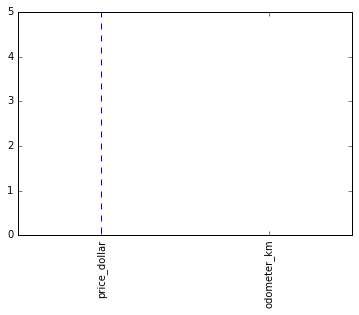

In [12]:
num_cols = ['price_dollar', 'odometer_km']
fig, ax= plt.subplots()
ax.boxplot(autos[num_cols].values)
ax.set_xticklabels(num_cols, rotation = 90)
ax.set_ylim(0,5)
plt.show()

In [13]:
# From the above boxplot its evident that price_dollar column has lots of outliers. Lets visulaize both the columns in different plots

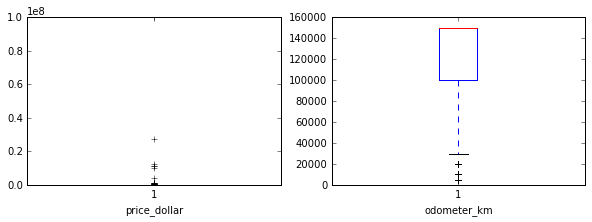

In [14]:
autos['price_dollar'].value_counts(dropna=False).sort_index(ascending = True)
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(autos['price_dollar'])
ax1.set_xlabel('price_dollar')

ax2.boxplot(autos['odometer_km'])
ax2.set_xlabel('odometer_km')

# the below plot shows extremely high ouliers in price column. Lets find the datapoints 1.5 times away from upperquartile and remove it.

## Remove outliers<a class="anchor" id="remove_outliers"></a>

Here we will look at two different methods to identify outliers.

** IQR Score **: The above plot (boxplot) uses IQR method to display datapoints. The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. The data points above Q2(upper quartile) or below Q1 (lower quartile) 1.5 * IQR 

* In real life scenario, removing data is not wise, hence the criteria can be made a bit stringent by calculating outliers as 3 * IQR than 1.5 * IQR to include most of the data. 


** Z-Score ** : The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. Since mean and standard deviation are highly affected by outliers, Zscore is comparatively less robust method because it depends on the mean and standard deviations to measure the central tendency and dispersion.

You will have to consider many parameters before excluding outliers like study objectives, model sensitivity towards outliers etc.

* The presence of such outliers are an indicator of real world data, hence its better to carry out further investigation to identify the source of outliers.

* Sometimes to retain the information from other variables the outliers are not deleted but winsorized (A typical strategy is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile.) Python code for winsorizing is as below:

   ---> scipy.stats.mstats.winsorize(a, limits = 0.05)


* Sometimes it is better to delete outliers for train models that are sensitive to outliers.

### IQR Score<a class="anchor" id="IQR"></a>

In [15]:
# Write a function to remove outliers using IQR
def outliers_IQR(data, col):
    lower_quartile = data[col].quantile(0.25)
    upper_quartile = data[col].quantile(0.75)
    IQR = upper_quartile - lower_quartile
    outlier_thresh = 1.5 * IQR
    return data[data[col].between((lower_quartile - outlier_thresh), (upper_quartile + outlier_thresh))]

autos_IQR = outliers_IQR(autos, 'price_dollar')
autos_IQR = outliers_IQR(autos_IQR, 'odometer_km')
autos_IQR.shape

(38366, 20)

This method removed 50,000 - 39,964 = 10,036 datapoints. This is 20% of the data, hence its not wise to remove so much data however as mentioned above it depends on the study objectives.

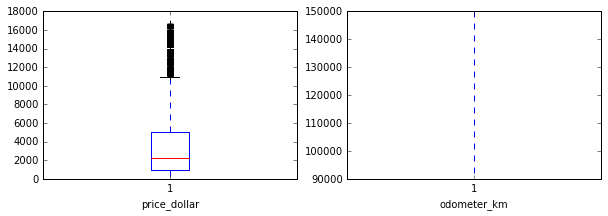

In [16]:
# Visualize data after removing outliers using IQR method
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(autos_IQR['price_dollar'])
ax1.set_xlabel('price_dollar')

ax2.boxplot(autos_IQR['odometer_km'])
ax2.set_xlabel('odometer_km')

### Z-Score<a class="anchor" id="z_score"></a>

In [17]:
def outliers_zscore(data, col, col_zscores):
    outlier_thresh = 3
    mean = data[col].mean()
    stdev = data[col].std()
    data[col_zscores] = (data[col] - mean) / stdev # compute zscore
    data = data[abs(data[col_zscores])<=3] # remove outliers
    return data.drop(col_zscores, axis=1) # drop zscore columns
    
    
autos_zscore = outliers_zscore(autos, 'price_dollar', 'price_zscores')
autos_zscore = outliers_zscore(autos_zscore, 'odometer_km', 'Odometer_zscores')
(50000 - autos_zscore.shape[0])/50000

0.05778

This method could only identify 6% of the data as outliers whereas only removed 20% of the data. It looks too suspicious as IQR identified 20% of the data to be outlier. Lets visualise our boxplots with outliers removed using zscore. 

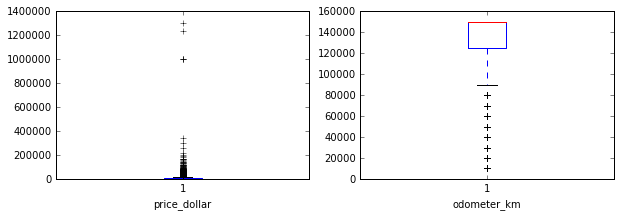

In [18]:
# Visualize data after removing outliers using Zscore method
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(autos_zscore['price_dollar'])
ax1.set_xlabel('price_dollar')

ax2.boxplot(autos_zscore['odometer_km'])
ax2.set_xlabel('odometer_km')

The boxplot still shows lot of outliers which zscore method could not identify as its mean and std deviations are also affected by large outliers.

# Missing Values<a class="anchor" id="missing_values"></a>

There are multiple ways to approach remove missing values

* Ignore missing values if you are working with large data

* Delete missing values for the models that are sensitive to it. The caveat here is, in this case we will lose a lot of information from the other columns as well.

* Impute missing values:
    * This can be acheived by replacing the missing values with mean, median, mode OR
    * Develop model to predict missing values
    
Whatever is the approach followed, the same approach needs to be followed for future data to maintain model consistency.

In [19]:
autos_IQR.isnull().sum()

date_crawled             0
name                     0
seller                   0
offer_type               0
price_dollar             0
abtest                   0
vehicle_type          2570
registration_year        0
gearbox               1865
powerps                  0
model                 1913
odometer_km              0
registration_month       0
fuel_type             3069
brand                    0
unrepaired_damage     7720
ad_created               0
number_pictures_ad       0
postal_code              0
last_seen                0
dtype: int64

Lets replace NAs with mode in this project, since all the columns with missing values is a categorical column.

In [20]:
# Replacing NAs with mode can be acheived with a one line code in python
# df.fillna(df.mode(), inplace=True)
# However because of some bug, you will have to modify the code in below format and run it seperately for each cat columns

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'unrepaired_damage']
for column in cat_cols:
    autos_IQR.fillna(autos_IQR[column].mode()[0], inplace=True)

In [21]:
autos_IQR.isnull().sum()
#All the NAs are imputed with mode values of each column

date_crawled          0
name                  0
seller                0
offer_type            0
price_dollar          0
abtest                0
vehicle_type          0
registration_year     0
gearbox               0
powerps               0
model                 0
odometer_km           0
registration_month    0
fuel_type             0
brand                 0
unrepaired_damage     0
ad_created            0
number_pictures_ad    0
postal_code           0
last_seen             0
dtype: int64